In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
!git clone https://github.com/Amey-2002/GSoC_2022_QMLHEP

Cloning into 'GSoC_2022_QMLHEP'...
remote: Enumerating objects: 111, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 111 (delta 61), reused 58 (delta 24), pack-reused 0
Receiving objects: 100% (111/111), 789.84 KiB | 2.18 MiB/s, done.
Resolving deltas: 100% (61/61), done.


In [ ]:
!rm -rf GSoC_2022_QMLHEP

In [ ]:
from IPython.display import clear_output
from google.colab import files
files.upload()
clear_output()

In [ ]:
from IPython.display import clear_output
from google.colab import files
files.upload()
clear_output()

In [ ]:
!pip install tensorflow-quantum==0.6.0 --use-deprecated=legacy-resolver

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%cd /content/GSoC_2022_QMLHEP/

/content/GSoC_2022_QMLHEP


## Getting the imports 

In [ ]:
import numpy as np
import tensorflow as tf
from h5py import File as HDF5File
from Quantum_Conv2D_layer import QConv2D_layer
from Entangled_QGANS import preprocess_utils, demo_circuits, model, swap_test_layer, frechet_inception_distance
%matplotlib inline
import matplotlib.pyplot as plt

## Fetching and Preprocessing the dataset

In [ ]:
electron_datafile = '/content/gdrive/MyDrive//electron.hdf5'
photon_datafile = '/content/gdrive/MyDrive//photon.hdf5'

In [ ]:
electron_data = HDF5File(electron_datafile, 'r')
photon_data = HDF5File(photon_datafile, 'r')

In [ ]:
X_electron = electron_data['X']

In [ ]:
X_electron.shape

(249000, 32, 32, 2)

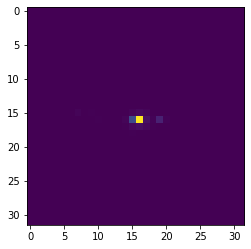

In [ ]:
plt.imshow(X_electron[0,:,:,0])

In [ ]:
X_electron = electron_data['X'][:,:,:,0]

In [ ]:
X_electron.shape

(249000, 32, 32)

In [ ]:
#preprocess the images(here: crop the images)
X_electron = preprocess_utils.crop_images(X_electron,(8,8))
X_electron = X_electron[:100]

In [ ]:
X_electron.shape

(100, 8, 8)

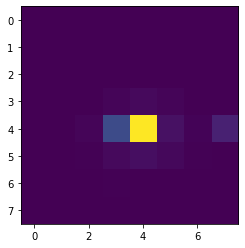

In [ ]:
plt.imshow(X_electron[0])

## Creating the Convolutional layers

In [ ]:
def generate_data(data_inputs,circuit_layers,filters,filter_shape,stride,c_id=''):

  conv_1 = QConv2D_layer(circuit_layers=circuit_layers[0], filter_shape=filter_shape[0],conv_id ='1'+c_id,
                      filters=filters[0], stride=stride[0], padding="same", parameter_sharing=False,seed=2021)(data_inputs)
  conv_2 = QConv2D_layer(circuit_layers=circuit_layers[1], filter_shape=filter_shape[1],conv_id = '2'+c_id,
                      filters=filters[1], stride=stride[1], padding="same", parameter_sharing=False,seed=2022)(conv_1)
  conv_output = tf.keras.layers.Flatten(name='Intermediate_output_layer_'+c_id)(conv_2)

  return conv_output

In [ ]:
def create_discriminator(real_data_inputs,gen_data_inputs,
                         circuit_layers,filters,filter_size,stride,
                         fidelity_test_params,optimizer,
                         use_sampled=False,backend=None,name='Discriminator'):
  
  conv_output_gen = generate_data(gen_data_inputs,circuit_layers=circuit_layers,filters=filters,filter_shape=filter_size,stride=stride,c_id='gen')
  conv_output_real = generate_data(real_data_inputs,circuit_layers=circuit_layers,filters=filters,filter_shape=filter_size,stride=stride,c_id='real')
  fidelity_test = swap_test_layer.SwapTestLayer(swap_test_symbol_values=fidelity_test_params)
  expectation_gen = fidelity_test([conv_output_real,conv_output_gen])
  expectation_gen = tf.add(expectation_gen,tf.constant(0.000001))
  log_disc_dist = tf.math.log(tf.keras.backend.flatten(expectation_gen))
  final_output = -log_disc_dist
  discriminator_model = tf.keras.Model(inputs=[real_data_inputs,gen_data_inputs],outputs=[final_output],name=name)
  disc_optimizer = optimizer(learning_rate=0.0001)
  disc_loss = lambda x,y: -tf.reduce_mean(y)
  discriminator_model.compile(optimizer=disc_optimizer,loss=disc_loss)

  return discriminator_model 

In [ ]:
def create_generator(real_data_inputs,gen_data_inputs,
                         circuit_layers,filters,filter_size,stride,
                         fidelity_test_params,optimizer,
                         use_sampled=False,backend=None,name='Generator'):
  
  conv_output_gen = generate_data(gen_data_inputs,circuit_layers=circuit_layers,filters=filters,filter_shape=filter_size,stride=stride,c_id='gen')
  conv_output_real = generate_data(real_data_inputs,circuit_layers=circuit_layers,filters=filters,filter_shape=filter_size,stride=stride,c_id='real')
  fidelity_test = swap_test_layer.SwapTestLayer(swap_test_symbol_values=fidelity_test_params)
  expectation_gen = fidelity_test([conv_output_real,conv_output_gen])
  expectation_gen = tf.add(expectation_gen,tf.constant(0.000001))
  log_gen_dist = tf.math.log(tf.keras.backend.flatten(expectation_gen))
  discriminator_model = tf.keras.Model(inputs=[real_data_inputs,gen_data_inputs],outputs=[expectation_gen,log_gen_dist],name=name)
  disc_optimizer = optimizer(learning_rate=0.0001)
  disc_loss = lambda x,y: -tf.reduce_mean(y)
  discriminator_model.compile(optimizer=disc_optimizer,loss=disc_loss,loss_weights=[0,1])
  
  return discriminator_model

In [ ]:
real_data_inputs = tf.keras.Input(shape=(X_electron.shape[1], X_electron.shape[2], ),dtype=tf.dtypes.float32,name='Input_layer_real')
gen_data_inputs = tf.keras.Input(shape=(X_electron.shape[1], X_electron.shape[2], ),dtype=tf.dtypes.float32,name='Input_layer_generated')
gen_layers = [2,2]
gen_filters = [1,1]
gen_filter_shape = [(3,3),(2,2)]  
gen_stride = [(2,2),(2,2)]

generator_model = create_generator(
    real_data_inputs=real_data_inputs,
    gen_data_inputs=gen_data_inputs,
    circuit_layers=gen_layers,
    filters=gen_filters,
    filter_size=gen_filter_shape,
    stride=gen_stride,
    fidelity_test_params= np.ndarray.flatten(np.array([0.5 , 1.0] * 4)),
    optimizer=tf.keras.optimizers.Adam,
    use_sampled=False,
    backend=None,name='Generator_Model')

In [ ]:
real_data_inputs = tf.keras.Input(shape=(X_electron.shape[1], X_electron.shape[2], ),dtype=tf.dtypes.float32,name='Input_layer_real')
gen_data_inputs = tf.keras.Input(shape=(X_electron.shape[1], X_electron.shape[2], ),dtype=tf.dtypes.float32,name='Input_layer_generated')
disc_layers = [2,2]
disc_filters = [1,1]
disc_filter_shape = [(3,3),(2,2)]  
disc_stride = [(2,2),(2,2)]

discriminator_model = discriminator_model = create_discriminator(                       
    real_data_inputs=real_data_inputs,
    gen_data_inputs=gen_data_inputs,
    circuit_layers=disc_layers,
    filters=disc_filters,
    filter_size=disc_filter_shape,
    stride=disc_stride,
    fidelity_test_params= np.ndarray.flatten(np.array([0.5 , 1.0] * 4)),
    optimizer=tf.keras.optimizers.Adam,
    use_sampled=False,
    backend=None,name='Discriminator_Model')

In [ ]:
generator_model.summary()
discriminator_model.summary()

Model: "Generator_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_layer_real (InputLayer)  [(None, 8, 8)]       0           []                               
                                                                                                  
 Input_layer_generated (InputLa  [(None, 8, 8)]      0           []                               
 yer)                                                                                             
                                                                                                  
 Quantum_Convolutional_Layer_wi  (None, 4, 4, 1)     864         ['Input_layer_real[0][0]']       
 th_padding1real (QConv2D_layer                                                                   
 )                                                                                  

In [ ]:
z_shape = tf.shape(X_electron)
z = tf.random.normal(z_shape)
print(tf.shape(z))

tf.Tensor([100   8   8], shape=(3,), dtype=int32)


In [ ]:
qgan = model.EntangledQGAN(generator_model=generator_model,discriminator_model=discriminator_model)

In [ ]:
gen_loss,disc_loss,param_history,state_overlap_list = qgan.train(real_data_inputs=X_electron,generator_data_inputs=z,
                                                                 batch_size=20,g_epochs=1,d_epochs=1,n_episodes=10) 

Step = 0:
discriminator_loss=[-0.4315235912799835]
generator_loss=[0.4586741328239441]
overlap=(0.9823477268218994+0j)
--------------------------------------------------
Step = 1:
discriminator_loss=[-0.4329822063446045]
generator_loss=[0.4594189524650574]
overlap=(0.9823113083839417+0j)
--------------------------------------------------
Step = 2:
discriminator_loss=[-0.43444332480430603]
generator_loss=[0.46016448736190796]
overlap=(0.9822737574577332+0j)
--------------------------------------------------
Step = 3:
discriminator_loss=[-0.4359079599380493]
generator_loss=[0.4609121084213257]
overlap=(0.982235848903656+0j)
--------------------------------------------------
Step = 4:
discriminator_loss=[-0.43737342953681946]
generator_loss=[0.46166062355041504]
overlap=(0.9821972846984863+0j)
--------------------------------------------------
Step = 5:
discriminator_loss=[-0.4388430714607239]
generator_loss=[0.4624113440513611]
overlap=(0.9821582436561584+0j)
----------------------------

Generating samples
Applying PCA to real data
Applying inverse PCA to generated samples
Generated Images:


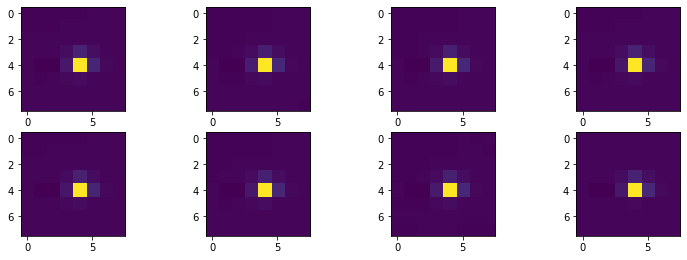

In [ ]:
qgan.create_images(X_electron,z)